In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import ops
from keras import layers, models
from keras import backend as K
from keras.callbacks import TensorBoard
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
# Connexion Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd drive/MyDrive/Colab Notebooks/data_sample_10000

/content/drive/MyDrive/Colab Notebooks/data_sample_10000


In [ ]:
#!unzip data_sample_10000.zip -d data_sample_10000

In [4]:
def format_img(id):
    '''

    Parameters
    ----------
    The identifier of the image to load


    Returns
    -------
    The image cropped and resized in a numpy array of shape (128, 128, 3)

    '''

    # Load the image and turn it into a numpy array
    image = Image.open(f'./{id}.jpg')

    #Size of the original image
    width, height = image.size

    # Normalization of the image
    # The image is centered and cropped to widthxwidth format
    """
    left = 0
    top = (height/2)-(width/2)
    right = width
    bottom = (height/2)+(width/2)
    """
    image = image.crop((0, 20, 178, 198))

    # Change of resolution to 128x128
    img_resized = image.resize((128, 128))

    # -1 to flatten, 3 for RGB channels
    image_np = np.array(img_resized) # do not flatten

    return image_np

In [5]:
data=[]

for i in range(1, 1001):
    id = f"{i:06}"  # Format the ID with 5 numbers, filled with zeroes on the left side
    data.append(format_img(id))
    if i%100==0:
        print(id)


data=np.array(data)
print(data.shape)


000100


KeyboardInterrupt: 

In [ ]:
data=data[0:1000]
# Normalization of the pixels
data=data/255

In [ ]:
# Allows you to choose an attribute by name
attributes_names = np.genfromtxt("list_attr_celeba.txt", dtype=str, skip_header=1, max_rows=1)
print(attributes_names)

my_attribute='Male'

index = np.where(attributes_names == f"{my_attribute}")[0]  # Return index table
print(index)
my_index=index[0]+1
print(my_index)

In [ ]:
attributes = np.loadtxt("list_attr_celeba.txt", skiprows=2, dtype='str')
attributes_short = attributes[0:1000]
genre = np.array(attributes_short[:,my_index], dtype=int)
unique, counts = np.unique(genre, return_counts=True)
unique = map(str, unique)
counts = map(int, counts)
headcounts=dict(zip(unique, counts))

# Allows you to see if the distribution of the attribute is balanced
print(f"{my_attribute} repartition {headcounts}")

In [ ]:
from keras import Model, Input

latent_dim = 32  #  latent space dimension

def build_encoder(input_shape=(128, 128, 3)):
    '''

    Parameters
    ----------
    The image of shape (128,128,3)

    Details
    -------
    The encoder (CNN) is structured as followed:
      - 2 Conv2D layers using 32 filters of size 3x3, with a stride of 1 to extract basic characteristics from each pixel of the image.
      - 1 MaxPooling layer using a filter of size 2x2, with a stride of 2 to reduce the size of feature map while preserving the most important information.
      - 2 more 2 Conv2D layers of 64 and 128 filters, followed alternately by MaxPooling layers
      - 1 flatten layer to flatten the multidimensional data into a 1D vector.
      - 1 dense (or fully connected) layer with 512 neurons.

    Then there is a variational part:
      - 2 dense layers perform a linear transformation to combine the 512 values and project them into a latent_dim dimension space using weight and bias.
      1 layer generate the mean of the latent distribution, the other generate the log-variance
      - 1 Lambda layer is used to limit the values of log-variance in the range [-10.0, 10.0] and to prevent them from becoming too large or too small,
      which could affect model stability during training.

    Then it use the function Sampling() to create a sample from the latent distribution using the previous mean, log_variance and an additionl noise.

    Returns
    -------
    A keras Model able to encode an image of shape (128,128,3) into a latent vector of size latent_dim


    '''

    img_input = Input(shape=input_shape, name="encoder_image_input")

    x = layers.Conv2D(32, 3, activation="relu", strides=1, padding="same")(img_input)
    x = layers.Conv2D(32, 3, activation="relu", strides=1, padding="same")(x)
    x = layers.MaxPooling2D(2,2)(x) #2x2 kernel size. Test with Conv2D kernel size = 2, stride 2 and no padding
    x = layers.Conv2D(64, 3, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", strides=1, padding="same")(x)
    x = layers.MaxPooling2D(2,2)(x)
    x = layers.Conv2D(128, 3, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", strides=1, padding="same")(x)
    x = layers.MaxPooling2D(2,2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation="relu")(x)

    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z_log_var = layers.Lambda(lambda t: tf.clip_by_value(t, -10.0, 10.0))(z_log_var)



    # Sampling layer
    def sampling(args):

        z_mean, z_log_var = args
        eps = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
        return z_mean + tf.exp(0.5 * z_log_var) * eps

    z = layers.Lambda(sampling, output_shape=(latent_dim,), name="z")([z_mean, z_log_var])
    #gender_logits = layers.Dense(1, activation="tanh")(z)  # output interval [-1, 1]

    encoder = Model([img_input], [z_mean, z_log_var, z], name="encoder")
    #encoder = Model([img_input, label_input], [z_mean, z_log_var, z, gender_logits], name="encoder")
    return encoder

In [ ]:
def build_decoder(output_shape=(128, 128, 3)):

    '''

    Parameters
    ----------
    The latent vector of size latent_dim

    Details
    -------
    The decoder is structured as followed:
      - 1 dense layer to extract information from the latent vector into a 1D vector of size 16 384 (8*8*256)
      - 1 reshape layer to reshape the vector to the shape (8, 8, 256). This corresponds to a "features map" of size 8x8 with 256 channels.
      This format is necessary to apply the following transposed convolution operations in the rest of the network.
      - 4 transposed convolution layers to increase the size of the image (doubling the width and height) while gradually reducing the number of channels (256 -> 128 -> 64 -> 32 -> 16)
      - One last transposed convolution layer generates the output image. It uses 3 filters, which corresponds the 3 channels of a RGB image.
      The sigmoid activation function is used here because it produces values between 0 and 1, to keep a normalized image.


    Returns
    -------
    A keras Model able to decode a latent vector of size latent_dim into an image of shape (128, 128, 3)

    '''

    latent_input = Input(shape=(latent_dim,), name="decoder_latent_input")
    x = layers.Dense(8 * 8 * 256, activation="relu")(latent_input)
    x = layers.Reshape((8, 8, 256))(x)

    x = layers.Conv2DTranspose(128, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(16, 3, strides=2, padding="same", activation="relu")(x)

    output_img = layers.Conv2DTranspose(output_shape[2], 3, activation="sigmoid", padding="same")(x)

    decoder = Model([latent_input], output_img, name="decoder")
    #decoder = Model([latent_input, label_input], output_img, name="decoder")
    return decoder

In [ ]:
class CVAE(keras.Model):
    def __init__(self, encoder, decoder, variational=False, **kwargs):
        '''

        Parameters
        ----------
          - The encoder and decoder models that the CVAE model will use to encode the input data and reconstruct it.
          - variational: a boolean optional argument which determines whether the model will be a classic VAE or a CVAE with loss KL.
            If variational=True, KL loss will be calculated in addition to the reconstruction loss.
          - **kwargs: allows to pass other arguments (such as data) to the parent class constructor keras. Model.


        Returns
        -------
        The image cropped and resized in a numpy array of shape (128, 128, 3)

        '''
        super(CVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")


        # Initialization of the attribute 'variational' to control KL loss
        self.variational = variational
        if self.variational:
            self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        else:
            self.kl_loss_tracker = None  # No KL loss if 'variational' is False

    @property
    def metrics(self):
      # Returns the metrics depending on whether KL is used or not
        metrics = [self.total_loss_tracker, self.reconstruction_loss_tracker]
        if self.variational and self.kl_loss_tracker is not None:
            metrics.append(self.kl_loss_tracker)
        return metrics


    def train_step(self, data):
        images=data
        #images, labels = data
        with tf.GradientTape() as tape:
            # Encoding
            z_mean, z_log_var, z = self.encoder([images])
            # Decoding
            reconstruction = self.decoder([z_mean])

            # The reconstruction_loss is calculated using the mean square error (MSE)
            # between the original image and the reconstruction, based on the dimensions of the image.
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_mean(
                    keras.losses.mean_squared_error(images, reconstruction), axis=(1, 2)
                )
            )
            # If variational=True, the KL loss is calculated as the Kullback-Leibler divergence
            # between the approximate distribution (defined by z_mean and z_log_var) and a standard normal distribution
            if self.variational:
              kl_loss = -0.5 * tf.reduce_mean(
                  tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
                  )
              # The total loss is the sum of the reconstruction loss and the KL loss, weighted by a factor 0.01
              total_loss = reconstruction_loss + 0.01 * kl_loss
              self.kl_loss_tracker.update_state(kl_loss)  # Update of KL loss
            else:
                total_loss = reconstruction_loss


        # Gradients computation and weights update
        # The gradients of the total loss versus the model weights are calculated and used to update the weights via the optimizer.
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Metrics update
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)


        # Save latent vectors during training (without using numpy)
        self.latent_vectors_history.append(z_mean)  # Directly adding tensors

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result() if self.variational else 0.0,
            #"gender_loss": gender_loss,
        }

In [ ]:
from tensorflow.keras.callbacks import Callback
class LatentSpaceVisualizationCallback(Callback):
    def __init__(self, frequency=10):  # Display frequency all X epochs
        super(LatentSpaceVisualizationCallback, self).__init__()
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.frequency == 0:  # Display visualizations at each epoch frequency
            print(f"Visualizing latent space at epoch {epoch + 1}...")
            self.plot_latent_space()

    def plot_latent_space(self):
        # Retrieve the latent vectors of the CVAE model
        latent_vectors = np.concatenate([latent_vector.numpy() for latent_vector in self.model.latent_vectors_history], axis=0)

        # Apply t-SNE to reduce the latent vectors to 2D
        tsne = TSNE(n_components=2)
        latent_2d = tsne.fit_transform(latent_vectors)

        # Visualization of projected latent vectors in 2D
        plt.figure(figsize=(8, 6))
        plt.scatter(latent_2d[:, 0], latent_2d[:, 1], alpha=0.5)
        plt.title(f"Latent Space with t-SNE (Epoch {len(self.model.latent_vectors_history)})")
        plt.xlabel("Latent Dimension 1")
        plt.ylabel("Latent Dimension 2")
        plt.show()


In [ ]:
encoder = build_encoder(input_shape=(128, 128, 3))
print(type(encoder))
decoder = build_decoder(output_shape=(128, 128, 3))
encoder.summary()

In [ ]:
decoder.summary()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data, genre, test_size=0.33, random_state=42)
x_t = x_train
print(len(x_test[0]))

In [ ]:
"""
# Enregistrement des loss
from keras.callbacks import TensorBoard
import datetime  # Pour générer un nom unique de dossier

# Définir un dossier pour les logs de TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

with tf.device('/device:GPU:0'):  # or '/device:CPU:0' if you want to use CPU
  summary_writer = tf.summary.create_file_writer(log_dir)
# Vérifier où sont stockés les logs
print(f"Logs enregistrés dans : {log_dir}")
"""

'\n# Enregistrement des loss\nfrom keras.callbacks import TensorBoard\nimport datetime  # Pour générer un nom unique de dossier\n\n# Définir un dossier pour les logs de TensorBoard\nlog_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")\n\nwith tf.device(\'/device:GPU:0\'):  # or \'/device:CPU:0\' if you want to use CPU\n  summary_writer = tf.summary.create_file_writer(log_dir)\n# Vérifier où sont stockés les logs\nprint(f"Logs enregistrés dans : {log_dir}")\n'

In [ ]:
#tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
# Create CVAE model
cvae = CVAE(encoder, decoder, variational=True)
#cvae = CVAE(encoder, decoder, variational=False)
cvae.latent_vectors_history = []  # Initialiser l'historique des vecteurs latents

# Create callback instance
latent_space_callback = LatentSpaceVisualizationCallback()

# Model compiling and training
cvae.compile(optimizer=keras.optimizers.Adam(clipnorm=1.0))
cvae.fit(x_t, epochs=100, batch_size=32)
#cvae.fit(x_t, epochs=100, batch_size=32, callbacks=[latent_space_callback]) Ne marche pas encore...

In [ ]:
"""
# Affichage des loss avec TensorBoard
# --> Vérifier la convergence
%load_ext tensorboard
%tensorboard --logdir logs/fit
"""

'\n# Affichage des loss avec TensorBoard\n# --> Vérifier la convergence\n%load_ext tensorboard\n%tensorboard --logdir logs/fit\n'

In [ ]:
z_mean, _, _ = cvae.encoder.predict(x_test, batch_size=32)

In [ ]:
import numpy as np

nan_rows = np.any(np.isnan(z_mean), axis=1)
print(f"Nb of samples containing NaN ：{np.sum(nan_rows)} / {len(z_mean)}")


In [ ]:
print(z_mean[:1])

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
# z_fixed = np.nan_to_num(z_mean, nan=0.0)  # replace all NaN by 0.0


# t-SNE (for decreasing the dimension, can also use PCA)
z_2d = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(z_mean)


In [ ]:
"""
y_colormap = (y_test.flatten() + 1) // 2

plt.figure(figsize=(10, 8))
scatter = plt.scatter(z_2d[:, 0], z_2d[:, 1], c=y_colormap, cmap="coolwarm", alpha=0.7)
plt.colorbar(scatter, ticks=[0, 1], label="Gender")
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.title("Latent Space Clustering by Gender")
plt.grid(True)
plt.show()
"""

'\ny_colormap = (y_test.flatten() + 1) // 2\n\nplt.figure(figsize=(10, 8))\nscatter = plt.scatter(z_2d[:, 0], z_2d[:, 1], c=y_colormap, cmap="coolwarm", alpha=0.7)\nplt.colorbar(scatter, ticks=[0, 1], label="Gender")\nplt.xlabel("z[0]")\nplt.ylabel("z[1]")\nplt.title("Latent Space Clustering by Gender")\nplt.grid(True)\nplt.show()\n'

# The gender clusters are not well seperated, but I tried to generate male/female images and it seems to be not bad...

In [ ]:
"""
import numpy as np
import matplotlib.pyplot as plt

# generate a random latent z
latent_dim = 32
z_sample = np.random.normal(size=(1, latent_dim))

# condition label：-1 = female，1 = male
label_male = np.array([[1]])
label_female = np.array([[-1]])

# generate male/female image
img_male = cvae.decoder.predict([z_sample, label_male])
img_female = cvae.decoder.predict([z_sample, label_female])

plt.figure(figsize=(4, 2))
plt.subplot(1, 2, 1)
plt.title("Male")
plt.imshow(img_male[0])
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Female")
plt.imshow(img_female[0])
plt.axis('off')
plt.show()
"""



'\nimport numpy as np\nimport matplotlib.pyplot as plt\n\n# generate a random latent z\nlatent_dim = 32\nz_sample = np.random.normal(size=(1, latent_dim))\n\n# condition label：-1 = female，1 = male\nlabel_male = np.array([[1]])\nlabel_female = np.array([[-1]])\n\n# generate male/female image\nimg_male = cvae.decoder.predict([z_sample, label_male])\nimg_female = cvae.decoder.predict([z_sample, label_female])\n\nplt.figure(figsize=(4, 2))\nplt.subplot(1, 2, 1)\nplt.title("Male")\nplt.imshow(img_male[0])\nplt.axis(\'off\')\n\nplt.subplot(1, 2, 2)\nplt.title("Female")\nplt.imshow(img_female[0])\nplt.axis(\'off\')\nplt.show()\n'

# Guide d'uitilisation : exemple de commandes

## Initialiser le modèle

In [ ]:
# Creat CVA model
cvae = CVAE(encoder, decoder, variational=True) # variational=False si on ne veut pas la partie variationelle

cvae.latent_vectors_history = []  # Initialiser l'historique des vecteurs latents

# Creat callback instance
latent_space_callback = LatentSpaceVisualizationCallback()

# CModel compiling and training
cvae.compile(optimizer=keras.optimizers.Adam(clipnorm=1.0))
cvae.fit(x_t, epochs=100, batch_size=32)

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 230ms/step - kl_loss: 0.0448 - loss: 0.0394 - reconstruction_loss: 0.0390
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - kl_loss: 0.0576 - loss: 0.0142 - reconstruction_loss: 0.0136
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - kl_loss: 0.0558 - loss: 0.0110 - reconstruction_loss: 0.0104
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - kl_loss: 0.0477 - loss: 0.0092 - reconstruction_loss: 0.0087
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - kl_loss: 0.0415 - loss: 0.0086 - reconstruction_loss: 0.0082
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - kl_loss: 0.0370 - loss: 0.0082 - reconstruction_loss: 0.0078
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - kl_loss: 0.0346 - loss: 0.0081 - reconstruction_loss: 0.0077
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - kl_loss: 0.0328 - loss: 0.0078 - reconstruction_loss: 0.0075
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - kl_loss: 0.0330 - loss: 

## Génération d'un vecteur latent V
## Etape 1 : Sélection d'une image originale

*   Exemple pour la 1ère image du tableau data : image_originale=data[0:1]

*   Attention : vérifier que l'image est bien de taille (1, 128, 128, 3)

In [26]:
image_originale=data[0:1]
image_originale.shape
# Image must be of shape (1, 128, 128, 3)

(1, 128, 128, 3)

## Etape 2 : Calcul d'un vecteur latent V


*   V=cvae.encoder.predict(image_originale, batch_size=32)[0]

In [39]:
V, _, _ = cvae.encoder.predict(image_originale, batch_size=32)
print(type(V))
print(V[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
<class 'numpy.ndarray'>
[-0.07510331  0.04646544  0.01814201 -0.01891414 -0.05349591  0.01313474
  0.08615145 -0.04960686 -0.0458586   0.01984057  0.03916124  0.03957833
  0.00065811  0.11809817  0.00359281 -0.05322983  0.05175439  0.00796879
  0.0100507   0.01836541 -0.0073023  -0.00641062  0.00794914  0.07876935
  0.01018884  0.08223625 -0.06521286 -0.02908887 -0.04657332 -0.11676531
  0.05393887  0.00438048]


## Construction d'une image à partir du vecteur latent V

## Etape 1 : Reconstitution d'une nouvelle image


*   nouvelle_image = cvae.decoder.predict([V])




In [28]:
nouvelle_image = cvae.decoder.predict([V])
print(nouvelle_image.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
(1, 128, 128, 3)


## Etape 2 : Affichage

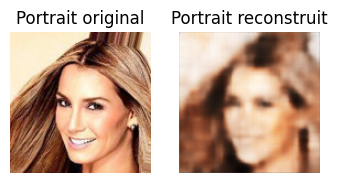

In [29]:
plt.figure(figsize=(4, 2))
plt.subplot(1, 2, 1)
plt.title("Portrait original")
plt.imshow(image_originale[0])
plt.axis('off')


plt.subplot(1, 2, 2)
plt.title("Portrait reconstruit")
plt.imshow(nouvelle_image[0])
plt.axis('off')
plt.show()

# Générer plusieurs vecteurs latents à partir d'images

## Etape 1 : Sélection des images
*   Exemple pour les 10ème et 11ème images du tableau data : images_originales=data[10:12]

In [42]:
images_originales=data[10:14]
images_originales.shape

(4, 128, 128, 3)

## Etape 2 : Calcul d'une matrice V contenant les vecteurs latents

*  V=cvae.encoder.predict(image_originale, batch_size=32)[0]


In [44]:
V, _, _ = cvae.encoder.predict(images_originales, batch_size=32)
print(V[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[ 0.0006391   0.01844062 -0.01775628  0.05146885  0.0316149  -0.04165341
 -0.06127427 -0.01313625 -0.02049509 -0.01231177 -0.03670804 -0.14858207
  0.01983303 -0.02043871  0.04200295 -0.00887425 -0.0099792  -0.04653525
  0.00512034 -0.08292814  0.05286478  0.06624622 -0.00098277 -0.07206697
  0.00833195  0.07773305  0.01859467 -0.0234019  -0.00263667  0.05177327
  0.05712711 -0.00490731]


# Générer plusieurs images latents à partir de plusieurs vecteurs latents

## Etape 1 : Reconstitution des nouvelles images


*   nouvelles_images = cvae.decoder.predict([V])


In [1]:
nouvelles_images = cvae.decoder.predict([V])
print(nouvelles_images.shape)

NameError: name 'cvae' is not defined

## Etape 2 : Affichage

In [ ]:
plt.figure(figsize =(4, 2))
plt.subplot(2, 2, 1)
plt.title("Portrait original 1")
plt.imshow(images_originales[0])
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title("Nouveau portrait 1")
plt.imshow(images_originales[0])
plt.axis('off')

plt.subplot(2, 2, 3)
plt.title("Portrait original 2")
plt.imshow(nouvelles_images[1])
plt.axis('off')



plt.subplot(2, 2, 4)
plt.title("Nouveau portrait 2")
plt.imshow(nouvelles_images[1])
plt.axis('off')
plt.show()
